# Metadata Cleaning

In [1]:
# Import dependencies
import os
import pandas as pd
import numpy as np
from scipy.stats import skew
from statistics import mean
import matplotlib.pyplot as plt

%run functions.ipynb

## Read in Files

In [2]:
# Raw dataset file path
rawdata_path = "../resources/voiced_dataset/"

# Get all the files in the directory
files = os.listdir(rawdata_path)

In [3]:
# Initialise the list to hold dictionaries
metadata_list = []

# Parse the data in the info files
for file in files:
    
    # Initialise the dictionary to store the info
    metadata_dict = dict()
    
    # Look through info files only
    if file.startswith("voice") and file.endswith("-info.txt"):
        
        # Read the text file
        with open(rawdata_path + file, 'r') as file:
            for line in file:
                
                # Split each line into a key-value pair using delimiter
                key, value = map(str.strip, line.split("\t"))
                
                # Ignore the empty lines by checking whitespaces
                if not line.strip():
                    continue
                else:
                    # Remove the colon
                    key = key.replace(":", "")
                    
                    # Load the data to a dictionary
                    metadata_dict[key] = value
                    
            # Append the dictionary to the list
            metadata_list.append(metadata_dict)

# Convert the list to a DataFrame
metadata_df = pd.DataFrame(metadata_list)
metadata_df.head()

,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
0,voice100,24,m,healthy,NU,0,5,no,NU,casual drinker,...,NU,never,always,3,sometimes,NU,almost always,NU,never,NU
1,voice101,60,m,healthy,NU,80,10,no,NU,nondrinker,...,NU,sometimes,always,4,sometimes,NU,sometimes,NU,never,NU
2,voice192,22,m,hyperkinetic dysphonia,Cook,0,10,no,NU,nondrinker,...,NU,sometimes,always,NU,always,NU,sometimes,NU,almost always,NU
3,voice193,46,f,hyperkinetic dysphonia,Housewife,0,36,yes,15,casual drinker,...,NU,sometimes,always,2,sometimes,NU,sometimes,NU,sometimes,NU
4,voice008,51,f,reflux laryngitis,Researcher,19,15,no,NU,casual drinker,...,NU,almost always,always,2,almost always,20g,sometimes,100 gr,almost always,1


## Clean `metadata_df`

In [4]:
# Check the dataframe
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 24 columns):
 #   Column                                                            Non-Null Count  Dtype 
---  ------                                                            --------------  ----- 
 0   ID                                                                208 non-null    object
 1   Age                                                               208 non-null    object
 2   Gender                                                            208 non-null    object
 3   Diagnosis                                                         208 non-null    object
 4   Occupation status                                                 208 non-null    object
 5   Voice Handicap Index (VHI) Score                                  208 non-null    object
 6   Reflux Symptom Index (RSI) Score                                  208 non-null    object
 7   Smoker                                      

### Check for duplicate IDs

In [5]:
# Check the ID distribution
metadata_df['ID'].value_counts()

ID
voice005    2
voice055    2
voice100    1
voice137    1
voice140    1
           ..
voice080    1
voice081    1
voice153    1
voice152    1
voice024    1
Name: count, Length: 206, dtype: int64

__NOTE__: Checked these info files individually, incorrect naming, appears to be duplicates.

In [6]:
# Display all the duplicate rows
duplicates = metadata_df.loc[metadata_df['ID']\
    .duplicated(keep=False)]\
    .sort_values(by='ID')\
    .copy()
duplicates

,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
99,voice005,54,f,hypokinetic dysphonia,Researcher,39,23,no,NU,casual drinker,...,NU,sometimes,never,NU,sometimes,150 gr,sometimes,200 gr,almost always,1
160,voice005,54,f,hypokinetic dysphonia,Researcher,39,25,no,NU,casual drinker,...,NU,sometimes,never,NU,sometimes,150 gr,sometimes,200 gr,almost always,1
121,voice055,46,m,hyperkinetic dysphonia,Technical operator,15,10,No,NU,nondrinker,...,NU,almost never,always,3,almost never,50 gr,sometimes,NU,never,NU
122,voice055,46,m,hyperkinetic dysphonia,Technical operator,15,19,No,NU,nondrinker,...,NU,almost never,always,3,almost never,50 gr,sometimes,NU,never,NU


__NOTE__: It appears there are slight differences, as in `Reflux Symptom Index (RSI) Score`.

In [7]:
# Determine which columns are different
dup_ids = duplicates['ID'].unique()

# Loop through each ID
for voice_id in dup_ids:
    
    # Isolate each voice ID
    df = duplicates.loc[duplicates['ID'] == voice_id]   
    display(df)
    
    # Isolate each row
    top_row = df.iloc[0]
    btm_row = df.iloc[1]
    
    # Compare each column
    compare = (top_row == btm_row)
    
    print(compare)

,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
99,voice005,54,f,hypokinetic dysphonia,Researcher,39,23,no,NU,casual drinker,...,NU,sometimes,never,NU,sometimes,150 gr,sometimes,200 gr,almost always,1
160,voice005,54,f,hypokinetic dysphonia,Researcher,39,25,no,NU,casual drinker,...,NU,sometimes,never,NU,sometimes,150 gr,sometimes,200 gr,almost always,1


ID                                                                   True
Age                                                                  True
Gender                                                               True
Diagnosis                                                            True
Occupation status                                                    True
Voice Handicap Index (VHI) Score                                     True
Reflux Symptom Index (RSI) Score                                    False
Smoker                                                               True
Number of cigarettes smoked per day                                  True
Alcohol consumption                                                  True
Number of glasses containing alcoholic beverage drinked in a day     True
Amount of water's litres drink every day                             True
Eating habits                                                        True
Carbonated beverages                  

,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
121,voice055,46,m,hyperkinetic dysphonia,Technical operator,15,10,No,NU,nondrinker,...,NU,almost never,always,3,almost never,50 gr,sometimes,NU,never,NU
122,voice055,46,m,hyperkinetic dysphonia,Technical operator,15,19,No,NU,nondrinker,...,NU,almost never,always,3,almost never,50 gr,sometimes,NU,never,NU


ID                                                                   True
Age                                                                  True
Gender                                                               True
Diagnosis                                                            True
Occupation status                                                    True
Voice Handicap Index (VHI) Score                                     True
Reflux Symptom Index (RSI) Score                                    False
Smoker                                                               True
Number of cigarettes smoked per day                                  True
Alcohol consumption                                                  True
Number of glasses containing alcoholic beverage drinked in a day     True
Amount of water's litres drink every day                             True
Eating habits                                                        True
Carbonated beverages                  

__NOTE__: It appears only the `Reflux Symptom Index (RSI) Score` is different.

In [8]:
# Take the average for each RSI score and update one instance
score_dict = dict()

# Loop through each ID
for voice_id in dup_ids:
    
    # Isolate each voice ID
    df = duplicates.loc[duplicates['ID'] == voice_id, 'Reflux Symptom Index (RSI) Score']

    # Get the average for each ID
    avg_val = int(df.astype(int).mean())
    
    # Append to the dictionary
    score_dict[voice_id] = avg_val
    
    # Print scores
    print(f'{voice_id}: {avg_val}')

voice005: 24
voice055: 14


In [9]:
# Drop one duplicated row
no_duplicates_df = metadata_df.drop_duplicates(
    keep = 'first',
    subset = 'ID'
)

# Confirm duplicated rows dropped
len(no_duplicates_df)

206

In [10]:
# Update the calculated RSI scores
for voice_id, score in score_dict.items():
    # Display the values to update
    print(voice_id, score)
    
    # Create a copy of the row
    row_copy = no_duplicates_df.loc[
        no_duplicates_df['ID'] == voice_id].copy()
    
    # Update the score on the copy
    row_copy['Reflux Symptom Index (RSI) Score'] = score
    
    # Update the dataframe
    no_duplicates_df.loc[no_duplicates_df['ID'] == voice_id] = row_copy

# Confirm updated correctly
no_duplicates_df.loc[no_duplicates_df['ID'].isin(score_dict.keys())]

voice005 24
voice055 14


,ID,Age,Gender,Diagnosis,Occupation status,Voice Handicap Index (VHI) Score,Reflux Symptom Index (RSI) Score,Smoker,Number of cigarettes smoked per day,Alcohol consumption,...,Amount of glasses drinked in a day,Tomatoes,Coffee,Number of cups of coffee drinked in a day,Chocolate,Gramme of chocolate eaten in a day,Soft cheese,Gramme of soft cheese eaten in a day,Citrus fruits,Number of citrus fruits eaten in a day
99,voice005,54,f,hypokinetic dysphonia,Researcher,39,24,no,NU,casual drinker,...,NU,sometimes,never,NU,sometimes,150 gr,sometimes,200 gr,almost always,1
121,voice055,46,m,hyperkinetic dysphonia,Technical operator,15,14,No,NU,nondrinker,...,NU,almost never,always,3,almost never,50 gr,sometimes,NU,never,NU


### Simplify the column names

In [11]:
# Print the columns
original_cols = list(no_duplicates_df.columns)
original_cols

['ID',
 'Age',
 'Gender',
 'Diagnosis',
 'Occupation status',
 'Voice Handicap Index (VHI) Score',
 'Reflux Symptom Index (RSI) Score',
 'Smoker',
 'Number of cigarettes smoked per day',
 'Alcohol consumption',
 'Number of glasses containing alcoholic beverage drinked in a day',
 "Amount of water's litres drink every day",
 'Eating habits',
 'Carbonated beverages',
 'Amount of glasses drinked in a day',
 'Tomatoes',
 'Coffee',
 'Number of cups of coffee drinked in a day',
 'Chocolate',
 'Gramme of chocolate eaten in  a day',
 'Soft cheese',
 'Gramme of soft cheese eaten in a day',
 'Citrus fruits',
 'Number of citrus fruits eaten in a day']

In [12]:
# Convert the column names to lower case
lowercase_cols = [col_name.lower() for col_name in original_cols]

# Create a copy of metadata_df
renamed_df = no_duplicates_df.copy()

# Update the column names
renamed_df.columns = lowercase_cols

# Display the DataFrame
renamed_df.head()

,id,age,gender,diagnosis,occupation status,voice handicap index (vhi) score,reflux symptom index (rsi) score,smoker,number of cigarettes smoked per day,alcohol consumption,...,amount of glasses drinked in a day,tomatoes,coffee,number of cups of coffee drinked in a day,chocolate,gramme of chocolate eaten in a day,soft cheese,gramme of soft cheese eaten in a day,citrus fruits,number of citrus fruits eaten in a day
0,voice100,24,m,healthy,NU,0,5,no,NU,casual drinker,...,NU,never,always,3,sometimes,NU,almost always,NU,never,NU
1,voice101,60,m,healthy,NU,80,10,no,NU,nondrinker,...,NU,sometimes,always,4,sometimes,NU,sometimes,NU,never,NU
2,voice192,22,m,hyperkinetic dysphonia,Cook,0,10,no,NU,nondrinker,...,NU,sometimes,always,NU,always,NU,sometimes,NU,almost always,NU
3,voice193,46,f,hyperkinetic dysphonia,Housewife,0,36,yes,15,casual drinker,...,NU,sometimes,always,2,sometimes,NU,sometimes,NU,sometimes,NU
4,voice008,51,f,reflux laryngitis,Researcher,19,15,no,NU,casual drinker,...,NU,almost always,always,2,almost always,20g,sometimes,100 gr,almost always,1


In [13]:
# Print updated columns
list(renamed_df.columns)

['id',
 'age',
 'gender',
 'diagnosis',
 'occupation status',
 'voice handicap index (vhi) score',
 'reflux symptom index (rsi) score',
 'smoker',
 'number of cigarettes smoked per day',
 'alcohol consumption',
 'number of glasses containing alcoholic beverage drinked in a day',
 "amount of water's litres drink every day",
 'eating habits',
 'carbonated beverages',
 'amount of glasses drinked in a day',
 'tomatoes',
 'coffee',
 'number of cups of coffee drinked in a day',
 'chocolate',
 'gramme of chocolate eaten in  a day',
 'soft cheese',
 'gramme of soft cheese eaten in a day',
 'citrus fruits',
 'number of citrus fruits eaten in a day']

In [14]:
# Simplify the column names
renamed_df = renamed_df.rename(columns={
    'voice handicap index (vhi) score': 'vhi score',
    'reflux symptom index (rsi) score': 'rsi score',
    'number of cigarettes smoked per day': 'cigarettes per day',
    'number of glasses containing alcoholic beverage drinked in a day': 'alcohol per day',
    "amount of water's litres drink every day": 'water litres per day',
    'amount of glasses drinked in a day': 'carbonated per day',
    'number of cups of coffee drinked in a day': 'coffee per day',
    'gramme of chocolate eaten in  a day': 'chocolate grams per day',
    'gramme of soft cheese eaten in a day': 'soft cheese per day',
    'number of citrus fruits eaten in a day': 'citrus fruits per day'
})

# Display the updated DataFrame
renamed_df.head()

,id,age,gender,diagnosis,occupation status,vhi score,rsi score,smoker,cigarettes per day,alcohol consumption,...,carbonated per day,tomatoes,coffee,coffee per day,chocolate,chocolate grams per day,soft cheese,soft cheese per day,citrus fruits,citrus fruits per day
0,voice100,24,m,healthy,NU,0,5,no,NU,casual drinker,...,NU,never,always,3,sometimes,NU,almost always,NU,never,NU
1,voice101,60,m,healthy,NU,80,10,no,NU,nondrinker,...,NU,sometimes,always,4,sometimes,NU,sometimes,NU,never,NU
2,voice192,22,m,hyperkinetic dysphonia,Cook,0,10,no,NU,nondrinker,...,NU,sometimes,always,NU,always,NU,sometimes,NU,almost always,NU
3,voice193,46,f,hyperkinetic dysphonia,Housewife,0,36,yes,15,casual drinker,...,NU,sometimes,always,2,sometimes,NU,sometimes,NU,sometimes,NU
4,voice008,51,f,reflux laryngitis,Researcher,19,15,no,NU,casual drinker,...,NU,almost always,always,2,almost always,20g,sometimes,100 gr,almost always,1


In [15]:
# Convert 'per day' to pd
renamed_cols = list(renamed_df.columns)

updated_cols = []
# Update each column
for col in renamed_cols:
    col = col.replace("per day", "pd")
    col = col.replace(" ", "_")
    updated_cols.append(col)

# Set the updated columns
renamed_df.columns = updated_cols

# Display the updated DataFrame
renamed_df.head()

,id,age,gender,diagnosis,occupation_status,vhi_score,rsi_score,smoker,cigarettes_pd,alcohol_consumption,...,carbonated_pd,tomatoes,coffee,coffee_pd,chocolate,chocolate_grams_pd,soft_cheese,soft_cheese_pd,citrus_fruits,citrus_fruits_pd
0,voice100,24,m,healthy,NU,0,5,no,NU,casual drinker,...,NU,never,always,3,sometimes,NU,almost always,NU,never,NU
1,voice101,60,m,healthy,NU,80,10,no,NU,nondrinker,...,NU,sometimes,always,4,sometimes,NU,sometimes,NU,never,NU
2,voice192,22,m,hyperkinetic dysphonia,Cook,0,10,no,NU,nondrinker,...,NU,sometimes,always,NU,always,NU,sometimes,NU,almost always,NU
3,voice193,46,f,hyperkinetic dysphonia,Housewife,0,36,yes,15,casual drinker,...,NU,sometimes,always,2,sometimes,NU,sometimes,NU,sometimes,NU
4,voice008,51,f,reflux laryngitis,Researcher,19,15,no,NU,casual drinker,...,NU,almost always,always,2,almost always,20g,sometimes,100 gr,almost always,1


### Convert `NU` values to `NaN`

In [16]:
# Create a copy of renamed
updated_df = renamed_df.copy()

# Convert the 'NU' values to 'NaN'
updated_df = updated_df.replace("NU", np.nan)

# Check the updated DataFrame info
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    206 non-null    object
 1   age                   206 non-null    object
 2   gender                206 non-null    object
 3   diagnosis             206 non-null    object
 4   occupation_status     165 non-null    object
 5   vhi_score             206 non-null    object
 6   rsi_score             206 non-null    object
 7   smoker                206 non-null    object
 8   cigarettes_pd         41 non-null     object
 9   alcohol_consumption   206 non-null    object
 10  alcohol_pd            25 non-null     object
 11  water_litres_pd       206 non-null    object
 12  eating_habits         206 non-null    object
 13  carbonated_beverages  206 non-null    object
 14  carbonated_pd         21 non-null     object
 15  tomatoes              206 non-null    object


In [17]:
# Display the columns with null values
cols_with_null = updated_df.columns[updated_df.isnull().any()]

# Display as a DataFrame
updated_nulls_df = updated_df[cols_with_null]
updated_nulls_df.head()

,occupation_status,cigarettes_pd,alcohol_pd,carbonated_pd,coffee_pd,chocolate_grams_pd,soft_cheese_pd,citrus_fruits_pd
0,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN
2,Cook,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Housewife,15,NaN,NaN,2,NaN,NaN,NaN
4,Researcher,NaN,NaN,NaN,2,20g,100 gr,1


### Clean categorical columns
- Except `diagnosis`, do this separately.

#### `gender` column

In [18]:
# Check the gender column
updated_df['gender'].value_counts(dropna=False)

gender
f    135
m     71
Name: count, dtype: int64

__NOTE__: `gender` column does not require cleaning.
___

#### `occupation_status` column

In [19]:
updated_df['occupation_status'].value_counts(dropna=False)

occupation_status
Researcher              42
NaN                     41
Employee                25
Housewife               23
Student                 16
Technical operator      13
Singer                  10
Pensioner                6
Doctor                   5
Teacher                  4
Merchant                 4
Hairstylist              2
Secretary                2
Unemployed               1
Male nurse               1
Cook                     1
Comptroller              1
Call center operator     1
Auto electrician         1
Fireman                  1
Beautician               1
Driver                   1
Blacksmith               1
Italian police           1
Librarian                1
Cobbler                  1
Name: count, dtype: int64

In [20]:
# Replace null values with 'Unknown'
updated_df['occupation_status'] = updated_df['occupation_status'].fillna('Unknown')

# Convert all to lowercase
updated_df['occupation_status'] = updated_df['occupation_status'].apply(str.lower)

# Confirm changes
updated_df['occupation_status'].value_counts(dropna=False)

occupation_status
researcher              42
unknown                 41
employee                25
housewife               23
student                 16
technical operator      13
singer                  10
pensioner                6
doctor                   5
teacher                  4
merchant                 4
hairstylist              2
secretary                2
unemployed               1
male nurse               1
cook                     1
comptroller              1
call center operator     1
auto electrician         1
fireman                  1
beautician               1
driver                   1
blacksmith               1
italian police           1
librarian                1
cobbler                  1
Name: count, dtype: int64

__NOTE__: Will need to bin these values to maximum of 10 unique if used as a feature.
___

#### `smoker` column

In [21]:
# Check the smoker column
updated_df['smoker'].value_counts(dropna=False)

smoker
no               97
No               55
yes              43
casual smoker    11
Name: count, dtype: int64

In [22]:
# Convert the 'No' to 'no'
updated_df['smoker'] = updated_df['smoker'].str.replace('No', 'no')

# Convert 'casual smoker' to 'casual'
updated_df['smoker'] = updated_df['smoker'].str.replace('casual smoker', 'casual')

# Display the updated values
updated_df['smoker'].value_counts(dropna=False)

smoker
no        152
yes        43
casual     11
Name: count, dtype: int64

Plan for encoding the `smoker` column
- `0` for `no`
- `1` for `casual`
- `2` for `yes`
___

#### `alcohol_consumption` column

In [23]:
# Check the alcohol_consumption column
updated_df['alcohol_consumption'].value_counts(dropna=False)

alcohol_consumption
casual drinker      100
nondrinker           83
habitual drinker     23
Name: count, dtype: int64

__NOTE__: `alcohol_consumption` column - cleaning required.

In [24]:
# Simplify the values for alcohol_consumption
updated_df['alcohol_consumption'] = updated_df['alcohol_consumption'].str.replace(" drinker", "")

# Check the updated values
updated_df['alcohol_consumption'].value_counts(dropna=False)

alcohol_consumption
casual        100
nondrinker     83
habitual       23
Name: count, dtype: int64

Plan for encoding `alcohol_consumption` column
- `0` for `nondrinker`
- `1` for `casual`
- `2` for `habitual`
___

#### `eating_habits` column

In [25]:
# Check the eating_habits column
updated_df['eating_habits']

0       
1       
2       
3       
4       
      ..
203     
204     
205     
206     
207     
Name: eating_habits, Length: 206, dtype: object

In [26]:
# Header in the text file, drop column
updated_df = updated_df.drop(columns=['eating_habits'])

In [27]:
# Check the eating habits columns
eating_habits = ['carbonated_beverages', 'tomatoes', 'coffee', 'chocolate', 'soft_cheese', 'citrus_fruits']

# Check unique values
unique_list = []
for col in eating_habits:
    unique_values = updated_df[col].unique()
    for val in unique_values:
        if val not in unique_list:
            unique_list.append(val)
print(unique_list)

['almost always', 'never', 'sometimes', 'almost never', 'always']


Encode the eating habits columns:
- `0` for `never`
- `1` for `almost_never`
- `2` for `sometimes`
- `3` for `almost_always`
- `4` for `always`
___

In [28]:
# Create a `clean_cat_df`
clean_cat_df = updated_df.copy()

### Clean numerical columns

In [29]:
# Isolate columns to convert to int type
convert_cols = ['age', 'vhi_score', 'rsi_score']

# Convert columns to int
clean_cat_df[convert_cols] = clean_cat_df[convert_cols].astype(int)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    206 non-null    object
 1   age                   206 non-null    int64 
 2   gender                206 non-null    object
 3   diagnosis             206 non-null    object
 4   occupation_status     206 non-null    object
 5   vhi_score             206 non-null    int64 
 6   rsi_score             206 non-null    int64 
 7   smoker                206 non-null    object
 8   cigarettes_pd         41 non-null     object
 9   alcohol_consumption   206 non-null    object
 10  alcohol_pd            25 non-null     object
 11  water_litres_pd       206 non-null    object
 12  carbonated_beverages  206 non-null    object
 13  carbonated_pd         21 non-null     object
 14  tomatoes              206 non-null    object
 15  coffee                206 non-null    object


#### `cigarettes_pd` column

In [30]:
# Check the smoker and cigarettes_pd columns
smoker_columns = ['smoker', 'cigarettes_pd']
clean_cat_df[smoker_columns].head()

,smoker,cigarettes_pd
0,no,NaN
1,no,NaN
2,no,NaN
3,yes,15
4,no,NaN


In [31]:
# Confirm the smokers have a valid value in the cigarettes_pd
smoker_null = (clean_cat_df['smoker'] == 'yes') & (clean_cat_df['cigarettes_pd'].isnull())
clean_cat_df.loc[smoker_null, smoker_columns]

,smoker,cigarettes_pd
40,yes,NaN
83,yes,NaN
138,yes,NaN
173,yes,NaN


__NOTE__: `yes` smokers should have a value for `cigarettes_pd`. Define a method for imputation.

Skewness: 1.030643653897744


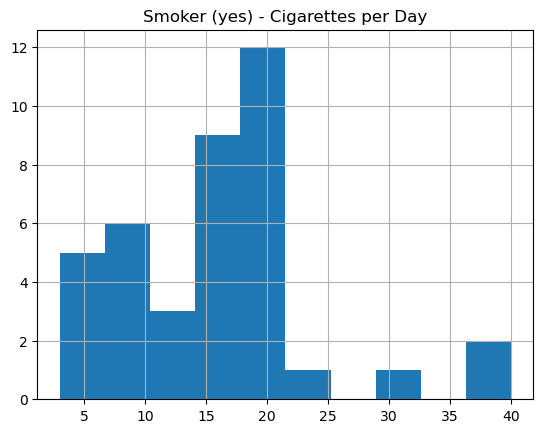

In [32]:
# Set the row conditions
smoker_notnull = (clean_cat_df['smoker'] == 'yes') & (~clean_cat_df['cigarettes_pd'].isnull())

# Create a copy of the series for plotting
num_cigarettes_df = clean_cat_df[smoker_notnull]['cigarettes_pd'].copy()

# Convert values for plotting
check_data = num_cigarettes_df.fillna(0).astype(int)

# Display a histogram of the cigarettes_pd column
check_data.hist()
plt.title('Smoker (yes) - Cigarettes per Day')

# Check skewness
print(f'Skewness: {skew(check_data)}')

__NOTE__: Skew value close to `1` means skewed to the right (shown in the histogram), use `median`.

In [33]:
# Calculate the median value (since skewed)
smoker_median = clean_cat_df.loc[smoker_notnull, 'cigarettes_pd'].astype(int).median()
print(f'Median cigarettes per day for smokers: {smoker_median}')

# Impute the missing values
clean_cat_df.loc[smoker_null, 'cigarettes_pd'] = smoker_median

Median cigarettes per day for smokers: 15.0


In [34]:
# Confirm the casual smokers have a valid value in the cigarettes_pd
casual_null = (clean_cat_df['smoker'] == 'casual') & (clean_cat_df['cigarettes_pd'].isnull())
clean_cat_df.loc[casual_null]

,id,age,gender,diagnosis,occupation_status,vhi_score,rsi_score,smoker,cigarettes_pd,alcohol_consumption,...,carbonated_pd,tomatoes,coffee,coffee_pd,chocolate,chocolate_grams_pd,soft_cheese,soft_cheese_pd,citrus_fruits,citrus_fruits_pd
33,voice069,63,m,reflux laryngitis,employee,11,10,casual,NaN,nondrinker,...,NaN,sometimes,always,NaN,sometimes,NaN,always,NaN,sometimes,NaN
35,voice161,65,m,hypokinetic dysphonia (glottic insufficiency),technical operator,45,0,casual,NaN,casual,...,NaN,sometimes,always,2,almost never,NaN,sometimes,NaN,almost never,NaN
45,voice155,33,f,hyperkinetic dysphonia,housewife,34,0,casual,NaN,nondrinker,...,NaN,sometimes,always,3,sometimes,NaN,sometimes,NaN,sometimes,NaN
84,voice106,21,m,hypokinetic dysphonia,unknown,35,13,casual,NaN,nondrinker,...,NaN,almost always,almost always,NaN,almost always,NaN,almost never,NaN,sometimes,NaN
100,voice004,28,f,hypokinetic dysphonia,researcher,20,9,casual,NaN,casual,...,NaN,sometimes,always,3,sometimes,NaN,almost always,NaN,sometimes,NaN
118,voice061,33,f,healthy,researcher,19,12,casual,NaN,habitual,...,NaN,almost always,almost always,2,sometimes,NaN,sometimes,NaN,almost never,NaN
127,voice163,44,f,hyperkinetic dysphonia,housewife,30,11,casual,NaN,nondrinker,...,NaN,sometimes,always,3,sometimes,NaN,almost never,NaN,sometimes,NaN
132,voice049,44,f,healthy,employee,4,20,casual,NaN,casual,...,NaN,sometimes,always,3,almost never,NaN,almost never,NaN,almost always,2
163,voice178,20,f,healthy,student,0,16,casual,NaN,nondrinker,...,NaN,almost never,sometimes,NaN,sometimes,NaN,sometimes,NaN,sometimes,NaN


In [35]:
# Check the casual smokers who have have a valid cigarettes_pd value
clean_cat_df.loc[clean_cat_df['smoker'] == 'casual', 'cigarettes_pd'].value_counts(dropna=False)

cigarettes_pd
NaN    9
2      2
Name: count, dtype: int64

__NOTE__:
- There are `9` `casual` smokers with an invalid `cigarettes_pd` value.
- There are only `2` `casual` smokers with a valid value of `2`.

In [36]:
# Use this value to impute missing values
casual_value = clean_cat_df.loc[clean_cat_df['smoker'] == 'casual', 'cigarettes_pd'].value_counts().mean()

# Impute the missing values
clean_cat_df.loc[casual_null, 'cigarettes_pd'] = casual_value

In [37]:
# Convert all other NaN values to `0`
clean_cat_df['cigarettes_pd'] = clean_cat_df['cigarettes_pd'].fillna(0)

# Convert the column type to an integer
clean_cat_df['cigarettes_pd'] = clean_cat_df['cigarettes_pd'].astype(int)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    206 non-null    object
 1   age                   206 non-null    int64 
 2   gender                206 non-null    object
 3   diagnosis             206 non-null    object
 4   occupation_status     206 non-null    object
 5   vhi_score             206 non-null    int64 
 6   rsi_score             206 non-null    int64 
 7   smoker                206 non-null    object
 8   cigarettes_pd         206 non-null    int64 
 9   alcohol_consumption   206 non-null    object
 10  alcohol_pd            25 non-null     object
 11  water_litres_pd       206 non-null    object
 12  carbonated_beverages  206 non-null    object
 13  carbonated_pd         21 non-null     object
 14  tomatoes              206 non-null    object
 15  coffee                206 non-null    object


#### `alcohol_pd` column

In [38]:
# Check the alcohol_consumption and alcohol_pd columns
alcohol_columns = ['alcohol_consumption', 'alcohol_pd']
clean_cat_df[alcohol_columns].tail()

,alcohol_consumption,alcohol_pd
203,casual,NaN
204,casual,NaN
205,casual,NaN
206,habitual,1
207,casual,NaN


In [39]:
# Update the nondrinker value to `0`
clean_cat_df.loc[clean_cat_df['alcohol_consumption'] == 'nondrinker', 'alcohol_pd'] = 0

In [40]:
# Check the count for all unique values
clean_cat_df['alcohol_pd'].value_counts(dropna=False)

alcohol_pd
NaN           98
0             83
1             10
2              6
2 per week     3
1 per week     1
3 per week     1
1/2            1
0.1            1
0.3            1
0,5            1
Name: count, dtype: int64

__NOTE__: Write a function to clean this column.

In [41]:
# Apply the clean_pd function to the column
clean_cat_df['alcohol_pd'] = clean_cat_df['alcohol_pd'].apply(clean_pd)

# Check the value counts
clean_cat_df['alcohol_pd'].value_counts(dropna=False)

alcohol_pd
NaN     98
0.00    83
1.00    10
2.00     6
0.29     3
0.14     1
0.43     1
1.50     1
0.10     1
0.30     1
0.50     1
Name: count, dtype: int64

In [42]:
# Check rows still with NaN
clean_cat_df.loc[clean_cat_df['alcohol_pd'].isnull(), alcohol_columns].value_counts(dropna=False)

alcohol_consumption  alcohol_pd
casual               NaN           90
habitual             NaN            8
Name: count, dtype: int64

__NOTE__: Similar process to the `smoker_pd` column, write a function for imputation.

['casual' 'nondrinker' 'habitual']


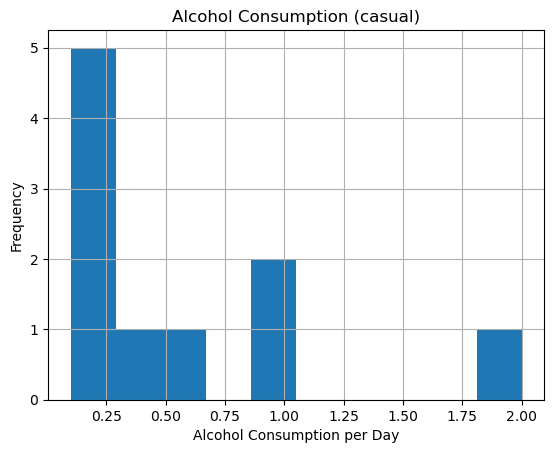

Skewness: 1.48, use MEDIAN.
Median value for "casual": 0.36


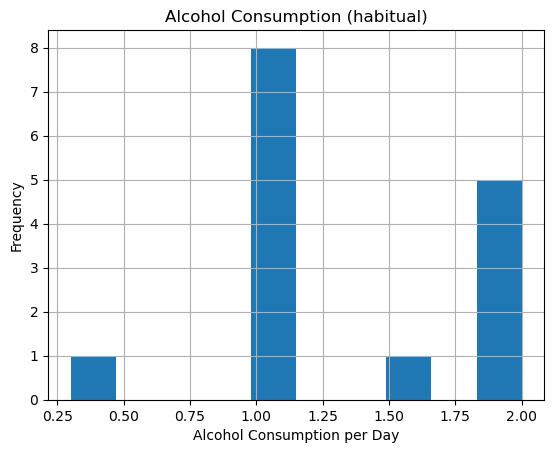

Skewness: 0.11, use MEAN.
Mean value for "habitual": 1.32


In [43]:
# Use the imputation() function
imputation(clean_cat_df, 'alcohol_consumption', 'alcohol_pd')

In [44]:
# Check the distribution and confirm the count
counts = clean_cat_df['alcohol_pd'].value_counts(dropna=False)
print(f'Total converted: {counts.sum()}\n{counts}')

Total converted: 206
alcohol_pd
0.36    90
0.00    83
1.00    10
1.32     8
2.00     6
0.29     3
0.14     1
0.43     1
1.50     1
0.10     1
0.30     1
0.50     1
Name: count, dtype: int64


In [45]:
# Convert the column to a float with 2 decimal points
clean_cat_df['alcohol_pd'] = clean_cat_df['alcohol_pd'].astype(float).round(2)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    206 non-null    object 
 1   age                   206 non-null    int64  
 2   gender                206 non-null    object 
 3   diagnosis             206 non-null    object 
 4   occupation_status     206 non-null    object 
 5   vhi_score             206 non-null    int64  
 6   rsi_score             206 non-null    int64  
 7   smoker                206 non-null    object 
 8   cigarettes_pd         206 non-null    int64  
 9   alcohol_consumption   206 non-null    object 
 10  alcohol_pd            206 non-null    float64
 11  water_litres_pd       206 non-null    object 
 12  carbonated_beverages  206 non-null    object 
 13  carbonated_pd         21 non-null     object 
 14  tomatoes              206 non-null    object 
 15  coffee                206 no

#### `water_litres_pd` column

In [46]:
# Check the water_litres_pd column
clean_cat_df['water_litres_pd'].value_counts(dropna=False)

water_litres_pd
1       77
2       59
1,5     57
0,5      6
2,5      4
0,75     2
0,25     1
Name: count, dtype: int64

__NOTE__: No null values, need to clean the commas.

In [47]:
# Apply the clean_pd function to the column
clean_cat_df['water_litres_pd'] = clean_cat_df['water_litres_pd'].apply(clean_pd)

# Check the value counts
clean_cat_df['water_litres_pd'].value_counts(dropna=False)

water_litres_pd
1.00    77
2.00    59
1.50    57
0.50     6
2.50     4
0.75     2
0.25     1
Name: count, dtype: int64

In [48]:
# Convert the column to a float with 2 decimal points
clean_cat_df['water_litres_pd'] = clean_cat_df['water_litres_pd'].astype(float).round(2)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    206 non-null    object 
 1   age                   206 non-null    int64  
 2   gender                206 non-null    object 
 3   diagnosis             206 non-null    object 
 4   occupation_status     206 non-null    object 
 5   vhi_score             206 non-null    int64  
 6   rsi_score             206 non-null    int64  
 7   smoker                206 non-null    object 
 8   cigarettes_pd         206 non-null    int64  
 9   alcohol_consumption   206 non-null    object 
 10  alcohol_pd            206 non-null    float64
 11  water_litres_pd       206 non-null    float64
 12  carbonated_beverages  206 non-null    object 
 13  carbonated_pd         21 non-null     object 
 14  tomatoes              206 non-null    object 
 15  coffee                206 no

#### `carbonated_pd` column

In [49]:
# Check the carbonated_pd column
clean_cat_df['carbonated_pd'].value_counts(dropna=False)

carbonated_pd
NaN               185
1                   8
3                   2
1 for week          2
2 for week          2
0.1                 2
2-3 for mounth      1
0.5                 1
2 for mounth        1
4                   1
0,5                 1
Name: count, dtype: int64

__NOTE__: Need to update the `clean_pd()` function

In [50]:
# Apply the clean_pd function to the column
clean_cat_df['carbonated_pd'] = clean_cat_df['carbonated_pd'].apply(clean_pd)

# Check the value counts
clean_cat_df['carbonated_pd'].value_counts(dropna=False)

carbonated_pd
NaN     185
1.00      8
3.00      2
0.14      2
0.50      2
0.29      2
0.10      2
0.08      1
0.07      1
4.00      1
Name: count, dtype: int64

In [51]:
# Check rows still with NaN
carbonated_columns = ['carbonated_beverages', 'carbonated_pd']
clean_cat_df.loc[clean_cat_df['carbonated_pd'].isnull(), carbonated_columns].value_counts(dropna=False)

carbonated_beverages  carbonated_pd
almost never          NaN              71
sometimes             NaN              56
never                 NaN              44
almost always         NaN              10
always                NaN               4
Name: count, dtype: int64

['almost always' 'never' 'sometimes' 'almost never' 'always']


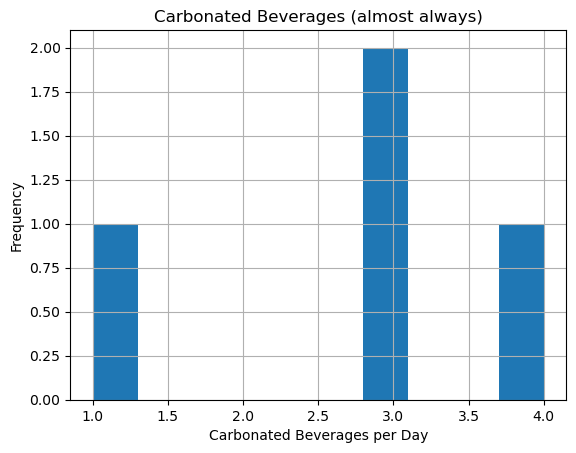

Skewness: -0.65, use MEDIAN.
Median value for "almost always": 3.0


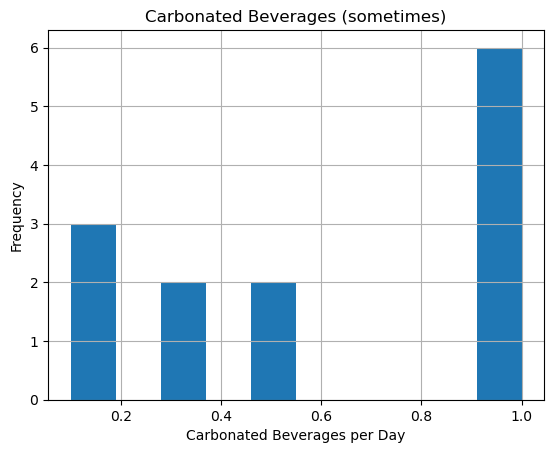

Skewness: -0.09, use MEAN.
Mean value for "sometimes": 0.61


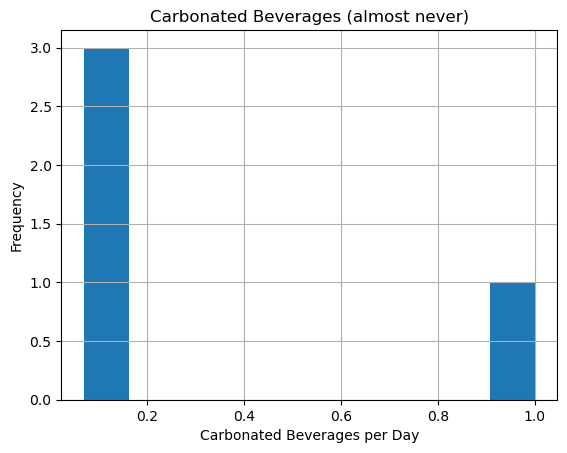

Skewness: 1.15, use MEDIAN.
Median value for "almost never": 0.09


In [52]:
# Use the imputation() function
imputation(clean_cat_df, 'carbonated_beverages', 'carbonated_pd')

In [53]:
# Check the distribution and confirm the count
counts = clean_cat_df['carbonated_pd'].value_counts(dropna=False)
print(f'Total converted: {counts.sum()}\n{counts}')

Total converted: 206
carbonated_pd
0.09    71
0.61    56
0.00    44
3.00    12
1.00     8
NaN      4
0.14     2
0.50     2
0.29     2
0.10     2
0.08     1
0.07     1
4.00     1
Name: count, dtype: int64


In [54]:
# Check the rows still with null values
clean_cat_df.loc[clean_cat_df['carbonated_pd'].isnull(), carbonated_columns].value_counts(dropna=False)

carbonated_beverages  carbonated_pd
always                NaN              4
Name: count, dtype: int64

__NOTE__: Null values still exist for `always` column since no valid value exists for its type.

In [55]:
# Check the distribution of per day values per unique value
carbonated_df = clean_cat_df[['carbonated_beverages', 'carbonated_pd']].copy()

# Group by the carbonated_beverages
grouped = carbonated_df.groupby('carbonated_beverages')['carbonated_pd']

# Check mean and median
print(f'Means: {grouped.mean()}\n')
print(f'Medians: {grouped.median()}')

Means: carbonated_beverages
almost always    2.928571
almost never     0.101867
always                NaN
never            0.000000
sometimes        0.610435
Name: carbonated_pd, dtype: float64

Medians: carbonated_beverages
almost always    3.00
almost never     0.09
always            NaN
never            0.00
sometimes        0.61
Name: carbonated_pd, dtype: float64


In [56]:
# Calculate the summary statistics for 'almost always'
almost_always = carbonated_df.loc[carbonated_df['carbonated_beverages'] == 'almost always']
summary_stats = almost_always.describe()
print(summary_stats)

max_value = almost_always['carbonated_pd'].max()
max_value

       carbonated_pd
count      14.000000
mean        2.928571
std         0.615728
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max         4.000000


4.0

In [57]:
# Use the max value from 'almost always' as 'always' value
clean_cat_df.loc[clean_cat_df['carbonated_beverages'] == 'always', 'carbonated_pd'] = max_value

# Confirm changes
clean_cat_df['carbonated_pd'].value_counts(dropna=False)

carbonated_pd
0.09    71
0.61    56
0.00    44
3.00    12
1.00     8
4.00     5
0.14     2
0.50     2
0.29     2
0.10     2
0.08     1
0.07     1
Name: count, dtype: int64

In [58]:
# Convert the column to a float with 2 decimal points
clean_cat_df['carbonated_pd'] = clean_cat_df['carbonated_pd'].astype(float).round(2)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    206 non-null    object 
 1   age                   206 non-null    int64  
 2   gender                206 non-null    object 
 3   diagnosis             206 non-null    object 
 4   occupation_status     206 non-null    object 
 5   vhi_score             206 non-null    int64  
 6   rsi_score             206 non-null    int64  
 7   smoker                206 non-null    object 
 8   cigarettes_pd         206 non-null    int64  
 9   alcohol_consumption   206 non-null    object 
 10  alcohol_pd            206 non-null    float64
 11  water_litres_pd       206 non-null    float64
 12  carbonated_beverages  206 non-null    object 
 13  carbonated_pd         206 non-null    float64
 14  tomatoes              206 non-null    object 
 15  coffee                206 no

#### `coffee_pd` column

In [59]:
# Check the coffee_pd column
clean_cat_df['coffee_pd'].value_counts(dropna=False)

coffee_pd
3      60
2      44
NaN    37
4      30
1      20
6       7
5       6
0       1
8       1
Name: count, dtype: int64

In [60]:
# Check the NaN values
coffee_columns = ['coffee', 'coffee_pd']
clean_cat_df.loc[clean_cat_df['coffee_pd'].isnull(), coffee_columns].value_counts(dropna=False)

coffee         coffee_pd
never          NaN          13
almost never   NaN           7
sometimes      NaN           7
almost always  NaN           5
always         NaN           5
Name: count, dtype: int64

['always' 'almost always' 'sometimes' 'never' 'almost never']


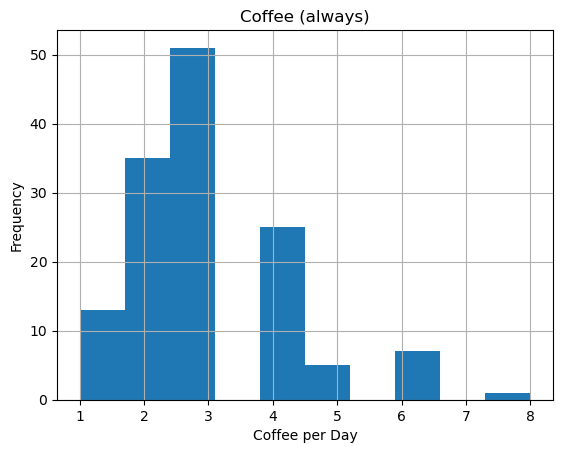

Skewness: 0.86, use MEDIAN.
Median value for "always": 3.0


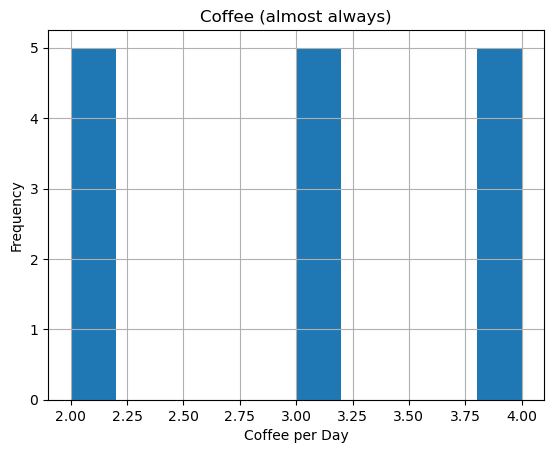

Skewness: 0.0, use MEAN.
Mean value for "almost always": 3.0


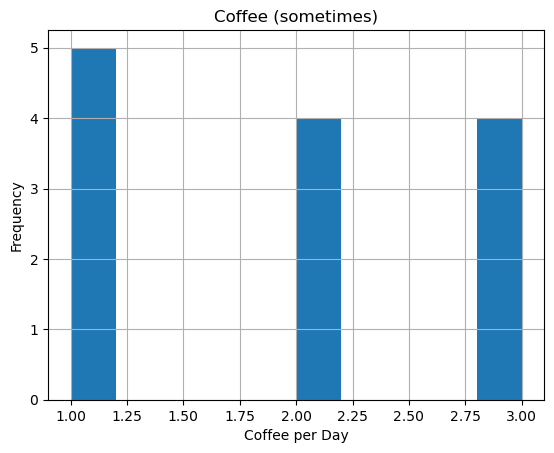

Skewness: 0.14, use MEAN.
Mean value for "sometimes": 1.92


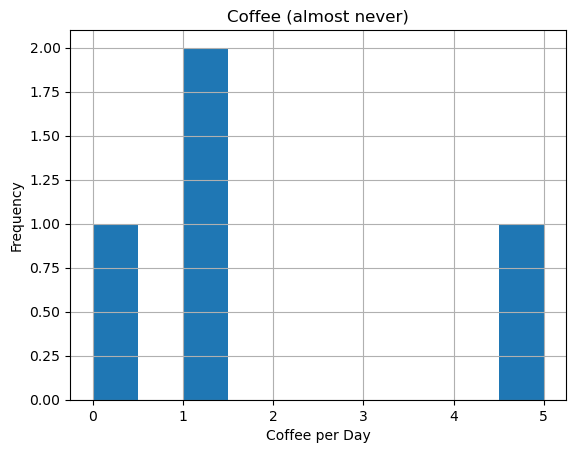

Skewness: 0.99, use MEDIAN.
Median value for "almost never": 1.0


In [61]:
# Use the imputation() function
imputation(clean_cat_df, 'coffee', 'coffee_pd')

In [62]:
# Check the distribution and confirm the count
counts = clean_cat_df['coffee_pd'].value_counts(dropna=False)
print(f'Total converted: {counts.sum()}\n{counts}')

Total converted: 206
coffee_pd
3       60
2       44
4       30
1       20
0       13
3.0     10
1.92     7
1.0      7
6        7
5        6
0        1
8        1
Name: count, dtype: int64


In [63]:
# Convert the column to a float
clean_cat_df['coffee_pd'] = clean_cat_df['coffee_pd'].astype(float)

# Since values are close to integers, cast to integers
clean_cat_df['coffee_pd'] = clean_cat_df['coffee_pd'].round(0).astype(int)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    206 non-null    object 
 1   age                   206 non-null    int64  
 2   gender                206 non-null    object 
 3   diagnosis             206 non-null    object 
 4   occupation_status     206 non-null    object 
 5   vhi_score             206 non-null    int64  
 6   rsi_score             206 non-null    int64  
 7   smoker                206 non-null    object 
 8   cigarettes_pd         206 non-null    int64  
 9   alcohol_consumption   206 non-null    object 
 10  alcohol_pd            206 non-null    float64
 11  water_litres_pd       206 non-null    float64
 12  carbonated_beverages  206 non-null    object 
 13  carbonated_pd         206 non-null    float64
 14  tomatoes              206 non-null    object 
 15  coffee                206 no

#### `chocolate_grams_pd` column

In [64]:
# Check the chocolate_grams_pd column
clean_cat_df['chocolate_grams_pd'].value_counts(dropna=False)

chocolate_grams_pd
NaN        172
20 gr        5
100 gr       5
50 gr        5
30 gr        5
10 gr        3
300 gr       1
25 gr        1
20g          1
1-2 gr       1
15 gr        1
3 gr         1
15 g         1
150 gr       1
25-50 g      1
2 gr         1
10g          1
Name: count, dtype: int64

__NOTE__: Adjust the `clean_pd()` function to account for `gr` and `g`.

In [65]:
# Apply the clean_pd function to the column
clean_cat_df['chocolate_grams_pd'] = clean_cat_df['chocolate_grams_pd'].apply(clean_pd)

# Check the value counts
clean_cat_df['chocolate_grams_pd'].value_counts(dropna=False)

chocolate_grams_pd
NaN     172
20        6
30        5
50        5
100       5
10        4
15        2
300       1
25        1
1.5       1
3         1
150       1
37.5      1
2         1
Name: count, dtype: int64

In [66]:
# Check the NaN values
choc_columns = ['chocolate', 'chocolate_grams_pd']
clean_cat_df.loc[clean_cat_df['chocolate_grams_pd'].isnull(), choc_columns].value_counts(dropna=False)

chocolate      chocolate_grams_pd
sometimes      NaN                   103
almost never   NaN                    42
almost always  NaN                    13
always         NaN                    11
never          NaN                     3
Name: count, dtype: int64

['sometimes' 'always' 'almost always' 'never' 'almost never']


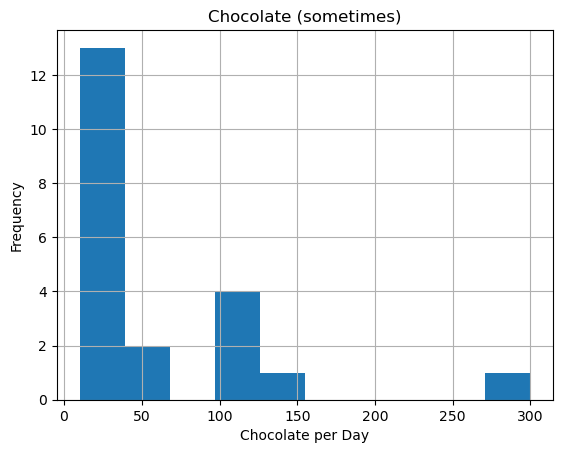

Skewness: 2.34, use MEDIAN.
Median value for "sometimes": 30.0


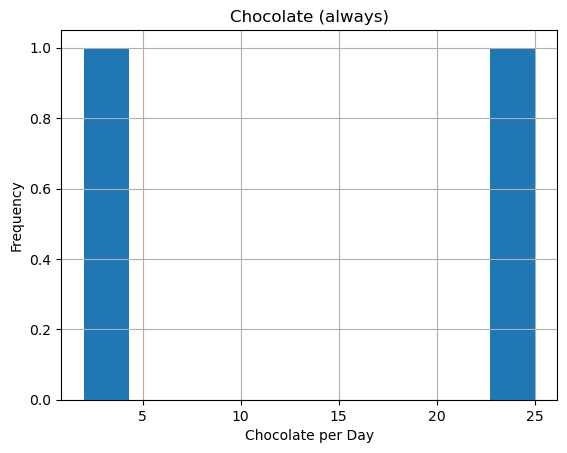

Skewness: 0.0, use MEAN.
Mean value for "always": 13.5


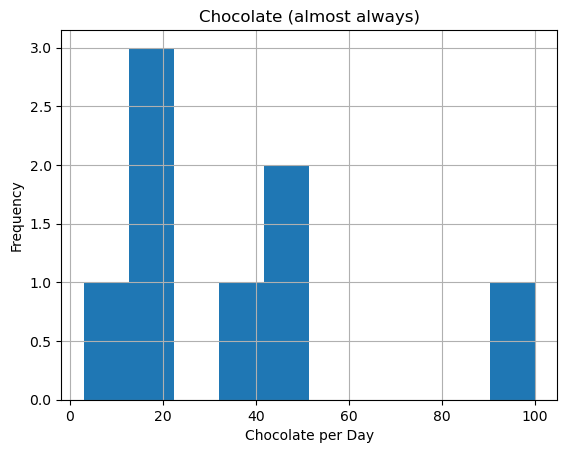

Skewness: 1.05, use MEDIAN.
Median value for "almost always": 28.75


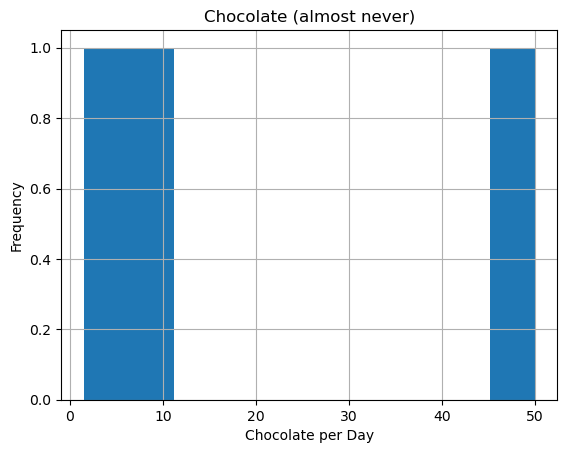

Skewness: 0.62, use MEDIAN.
Median value for "almost never": 10.0


In [67]:
# Use the imputation() function
imputation(clean_cat_df, 'chocolate', 'chocolate_grams_pd')

In [68]:
# Check the distribution and confirm the count
counts = clean_cat_df['chocolate_grams_pd'].value_counts(dropna=False)
print(f'Total converted: {counts.sum()}\n{counts}')

Total converted: 206
chocolate_grams_pd
30.0     103
10.0      42
28.75     13
13.5      11
20         6
100        5
30         5
50         5
10         4
0          3
15         2
37.5       1
150        1
300        1
3          1
1.5        1
25         1
2          1
Name: count, dtype: int64


In [69]:
# Convert the column to a float
clean_cat_df['chocolate_grams_pd'] = clean_cat_df['chocolate_grams_pd'].astype(float)

# Since values are close to integers, cast to integers
clean_cat_df['chocolate_grams_pd'] = clean_cat_df['chocolate_grams_pd'].round(0).astype(int)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    206 non-null    object 
 1   age                   206 non-null    int64  
 2   gender                206 non-null    object 
 3   diagnosis             206 non-null    object 
 4   occupation_status     206 non-null    object 
 5   vhi_score             206 non-null    int64  
 6   rsi_score             206 non-null    int64  
 7   smoker                206 non-null    object 
 8   cigarettes_pd         206 non-null    int64  
 9   alcohol_consumption   206 non-null    object 
 10  alcohol_pd            206 non-null    float64
 11  water_litres_pd       206 non-null    float64
 12  carbonated_beverages  206 non-null    object 
 13  carbonated_pd         206 non-null    float64
 14  tomatoes              206 non-null    object 
 15  coffee                206 no

#### `soft_cheese_pd` column

In [70]:
# Check the soft_cheese_pd column
clean_cat_df['soft_cheese_pd'].value_counts(dropna=False)

soft_cheese_pd
NaN              174
100 gr             9
200 gr             6
50 gr              5
20 gr              2
150 gr/ month      2
100/150 gr         1
400 gr             1
30 gr              1
100  gr            1
150/200 gr         1
150 gr             1
100 g              1
300 gr.            1
Name: count, dtype: int64

__NOTE__: Need to adjust `clean_pd()` function again, need to be careful with added complexity.

In [71]:
# Apply the clean_pd function to the column
clean_cat_df['soft_cheese_pd'] = clean_cat_df['soft_cheese_pd'].apply(clean_pd)

# Check the value counts
clean_cat_df['soft_cheese_pd'].value_counts(dropna=False)

soft_cheese_pd
NaN    174
100     11
200      6
50       5
20       2
5.0      2
125      1
400      1
30       1
175      1
150      1
300      1
Name: count, dtype: int64

In [72]:
# Check the NaN values
cheese_columns = ['soft_cheese', 'soft_cheese_pd']
clean_cat_df.loc[clean_cat_df['soft_cheese_pd'].isnull(), cheese_columns].value_counts(dropna=False)

soft_cheese    soft_cheese_pd
sometimes      NaN               121
almost never   NaN                28
almost always  NaN                14
always         NaN                 7
never          NaN                 4
Name: count, dtype: int64

['almost always' 'sometimes' 'almost never' 'always' 'never']


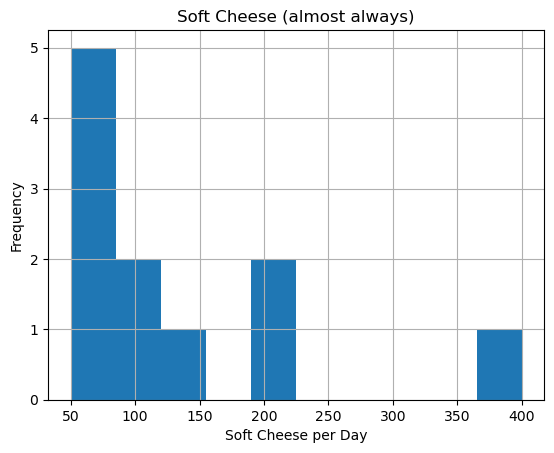

Skewness: 1.55, use MEDIAN.
Median value for "almost always": 100.0


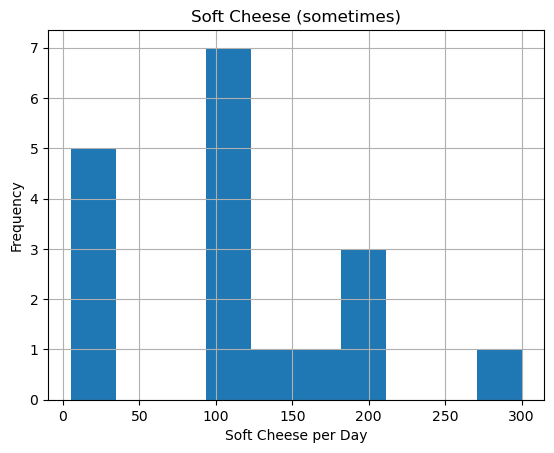

Skewness: 0.58, use MEDIAN.
Median value for "sometimes": 100.0


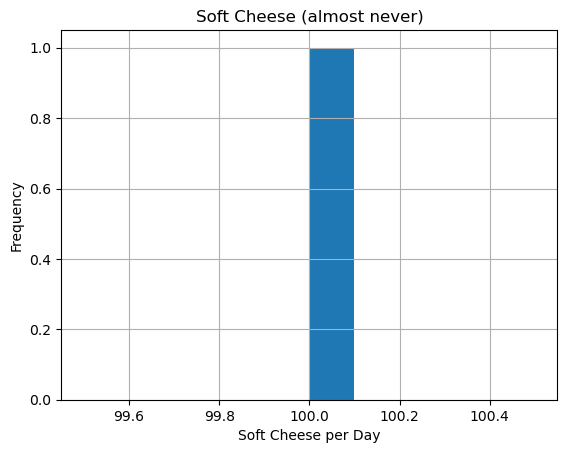

Skewness: nan, use MEAN.
Mean value for "almost never": 100.0


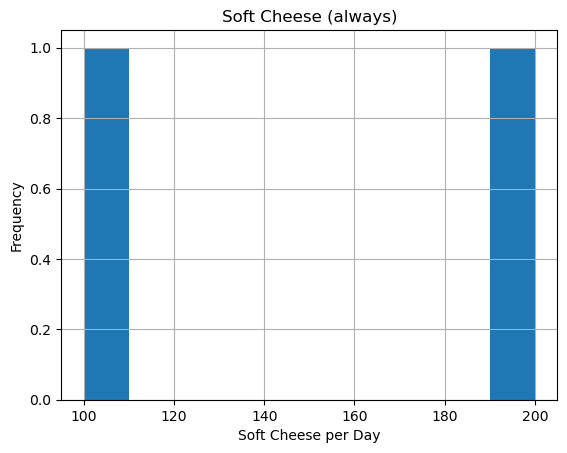

Skewness: 0.0, use MEAN.
Mean value for "always": 150.0


In [73]:
# Use the imputation() function
imputation(clean_cat_df, 'soft_cheese', 'soft_cheese_pd')

In [74]:
# Check the distribution and confirm the count
counts = clean_cat_df['soft_cheese_pd'].value_counts(dropna=False)
print(f'Total converted: {counts.sum()}\n{counts}')

Total converted: 206
soft_cheese_pd
100.0    163
100       11
150.0      7
200        6
50         5
0          4
20         2
5.0        2
125        1
400        1
30         1
175        1
150        1
300        1
Name: count, dtype: int64


In [75]:
# Convert the column to a float
clean_cat_df['soft_cheese_pd'] = clean_cat_df['soft_cheese_pd'].astype(float)

# Since values are close to integers, cast to integers
clean_cat_df['soft_cheese_pd'] = clean_cat_df['soft_cheese_pd'].round(0).astype(int)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    206 non-null    object 
 1   age                   206 non-null    int64  
 2   gender                206 non-null    object 
 3   diagnosis             206 non-null    object 
 4   occupation_status     206 non-null    object 
 5   vhi_score             206 non-null    int64  
 6   rsi_score             206 non-null    int64  
 7   smoker                206 non-null    object 
 8   cigarettes_pd         206 non-null    int64  
 9   alcohol_consumption   206 non-null    object 
 10  alcohol_pd            206 non-null    float64
 11  water_litres_pd       206 non-null    float64
 12  carbonated_beverages  206 non-null    object 
 13  carbonated_pd         206 non-null    float64
 14  tomatoes              206 non-null    object 
 15  coffee                206 no

#### `citrus_fruits_pd` column

In [76]:
# Check the citrus_fruits_pd column
clean_cat_df['citrus_fruits_pd'].value_counts(dropna=False)

citrus_fruits_pd
NaN             158
1                21
2                11
1-2               3
3                 3
1/2               2
1/2 for week      1
90                1
2 for week        1
200 gramme        1
150 gramme        1
100 gramme        1
3 for week        1
1 for week        1
Name: count, dtype: int64

__NOTE__: Write a function to convert the gram-value to number of fruits.

In [77]:
# Apply the fruit_gram function to the column
clean_cat_df['citrus_fruits_pd'] = clean_cat_df['citrus_fruits_pd'].apply(fruit_gram)

# Check the value counts
clean_cat_df['citrus_fruits_pd'].value_counts(dropna=False)

citrus_fruits_pd
NaN             158
1.0              22
2.0              11
1-2               3
3.0               3
1/2               2
1/2 for week      1
0.6               1
2 for week        1
1.33              1
0.67              1
3 for week        1
1 for week        1
Name: count, dtype: int64

In [78]:
# Apply the clean_pd function to the column
clean_cat_df['citrus_fruits_pd'] = clean_cat_df['citrus_fruits_pd'].apply(clean_pd)

# Check the value counts
clean_cat_df['citrus_fruits_pd'].value_counts(dropna=False)

citrus_fruits_pd
NaN     158
1.00     22
2.00     11
1.50      5
3.00      3
0.14      2
0.60      1
0.29      1
1.33      1
0.67      1
0.43      1
Name: count, dtype: int64

In [79]:
# Check the NaN values
citrus_columns = ['citrus_fruits', 'citrus_fruits_pd']
clean_cat_df.loc[clean_cat_df['citrus_fruits_pd'].isnull(), citrus_columns].value_counts(dropna=False)

citrus_fruits  citrus_fruits_pd
sometimes      NaN                 92
almost never   NaN                 33
almost always  NaN                 16
never          NaN                 13
always         NaN                  4
Name: count, dtype: int64

['never' 'almost always' 'sometimes' 'always' 'almost never']


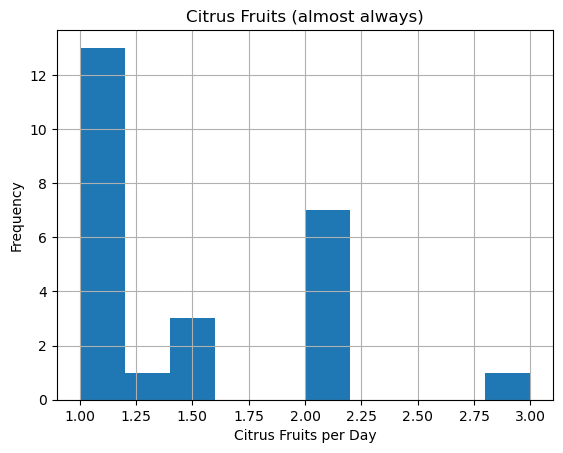

Skewness: 1.06, use MEDIAN.
Median value for "almost always": 1.0


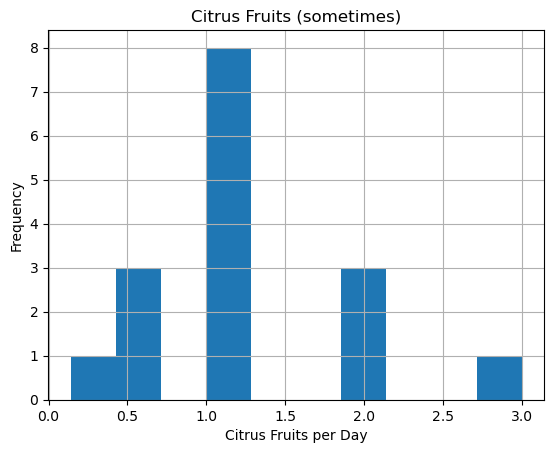

Skewness: 1.06, use MEDIAN.
Median value for "sometimes": 1.0


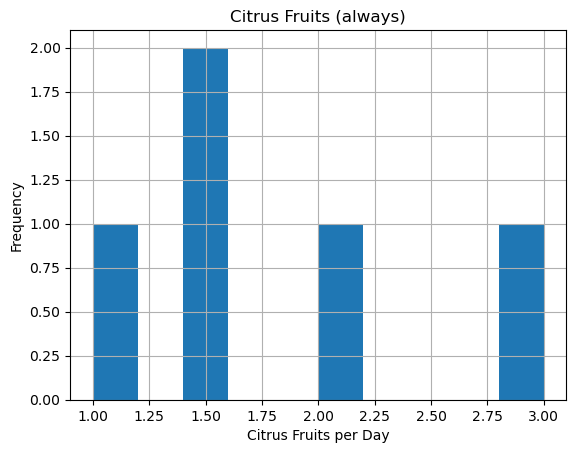

Skewness: 0.75, use MEDIAN.
Median value for "always": 1.5


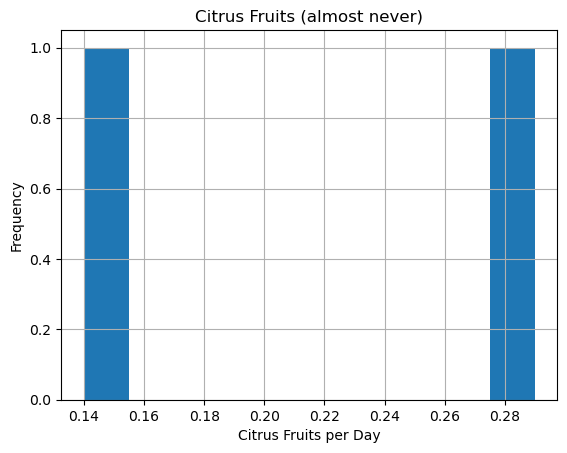

Skewness: 0.0, use MEAN.
Mean value for "almost never": 0.22


In [80]:
# Use the imputation() function
imputation(clean_cat_df, 'citrus_fruits', 'citrus_fruits_pd')

In [81]:
# Check the distribution and confirm the count
counts = clean_cat_df['citrus_fruits_pd'].value_counts(dropna=False)
print(f'Total converted: {counts.sum()}\n{counts}')

Total converted: 206
citrus_fruits_pd
1.00    130
0.22     33
0.00     13
2.00     11
1.50      9
3.00      3
0.14      2
0.60      1
0.29      1
1.33      1
0.67      1
0.43      1
Name: count, dtype: int64


In [82]:
# Determine whether to cast to int or retain float
citrus_columns = ['citrus_fruits', 'citrus_fruits_pd']
clean_cat_df[citrus_columns].value_counts(dropna=False).sort_index()

citrus_fruits  citrus_fruits_pd
almost always  1.00                 29
               1.33                  1
               1.50                  3
               2.00                  7
               3.00                  1
almost never   0.14                  1
               0.22                 33
               0.29                  1
always         1.00                  1
               1.50                  6
               2.00                  1
               3.00                  1
never          0.00                 13
sometimes      0.14                  1
               0.43                  1
               0.60                  1
               0.67                  1
               1.00                100
               2.00                  3
               3.00                  1
Name: count, dtype: int64

In [83]:
# Convert the column to a float with 2 decimal points
clean_cat_df['citrus_fruits_pd'] = clean_cat_df['citrus_fruits_pd'].astype(float).round(2)

# Confirm changes
clean_cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206 entries, 0 to 207
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    206 non-null    object 
 1   age                   206 non-null    int64  
 2   gender                206 non-null    object 
 3   diagnosis             206 non-null    object 
 4   occupation_status     206 non-null    object 
 5   vhi_score             206 non-null    int64  
 6   rsi_score             206 non-null    int64  
 7   smoker                206 non-null    object 
 8   cigarettes_pd         206 non-null    int64  
 9   alcohol_consumption   206 non-null    object 
 10  alcohol_pd            206 non-null    float64
 11  water_litres_pd       206 non-null    float64
 12  carbonated_beverages  206 non-null    object 
 13  carbonated_pd         206 non-null    float64
 14  tomatoes              206 non-null    object 
 15  coffee                206 no

In [84]:
# Create a `clean_num_df`
clean_num_df = clean_cat_df.copy()

### Clean target variable: `diagnosis`

In [85]:
# Check the diagnosis column
clean_num_df['diagnosis'].value_counts(dropna=False)

diagnosis
healthy                                                57
hyperkinetic dysphonia                                 42
reflux laryngitis                                      38
hypokinetic dysphonia                                  21
hyperkinetic dysphonia (Prolapse)                       9
hypokinetic dysphonia (glottic insufficiency)           6
hyperkinetic dysphonia (Polyps)                         5
hypokinetic dysphonia (Vocal fold paralysis)            4
hyperkinetic dysphonia (Reinke's edema)                 3
hyperkinetic dysphonia (nodule)                         3
hyperkinetic dysphonia (Nodule)                         2
hypokinetic dysphonia (Extraglottic air leak)           1
hypokinetic dysphonia (Glottic insufficiency)           1
hypokinetic dysphonia (Dysphonia by chordal groove)     1
hyperkinetic dysphonia (polyps)                         1
hyperkinetic dysphonia (Adduction deficit)              1
hypokinetic dysphonia (Adduction deficit)               1
hypo

In [86]:
# Pattern to get text in brackets
subtype_pattern = '\((.*?)\)'

# Pattern to get the rest of the text
base_pattern = '^(.*?)\('

# Get subtypes in lowercase
clean_num_df['subtype'] = clean_num_df['diagnosis']\
    .apply(str.lower)\
    .str.extract(subtype_pattern)

# Get the base in lowercase
clean_num_df['base'] = clean_num_df['diagnosis']\
    .apply(str.lower)\
    .str.extract(base_pattern)

# Display the updated columns
clean_num_df[['diagnosis', 'base', 'subtype']].head(10)

,diagnosis,base,subtype
0,healthy,NaN,NaN
1,healthy,NaN,NaN
2,hyperkinetic dysphonia,NaN,NaN
3,hyperkinetic dysphonia,NaN,NaN
4,reflux laryngitis,NaN,NaN
5,hyperkinetic dysphonia (nodule),hyperkinetic dysphonia,nodule
6,hyperkinetic dysphonia,NaN,NaN
7,hypokinetic dysphonia (Presbiphonia),hypokinetic dysphonia,presbiphonia
8,reflux laryngitis,NaN,NaN
9,healthy,NaN,NaN


In [87]:
# Fill the base null values with the diagnosis value and lowercase
clean_num_df['base'] = clean_num_df['base'].fillna(clean_num_df['diagnosis'])

# Fill the subtype null values with 'no subtype'
clean_num_df['subtype'] = clean_num_df['subtype'].fillna('no subtype')

# Display the updated columns
clean_num_df[['diagnosis', 'base', 'subtype']].head(10)

,diagnosis,base,subtype
0,healthy,healthy,no subtype
1,healthy,healthy,no subtype
2,hyperkinetic dysphonia,hyperkinetic dysphonia,no subtype
3,hyperkinetic dysphonia,hyperkinetic dysphonia,no subtype
4,reflux laryngitis,reflux laryngitis,no subtype
5,hyperkinetic dysphonia (nodule),hyperkinetic dysphonia,nodule
6,hyperkinetic dysphonia,hyperkinetic dysphonia,no subtype
7,hypokinetic dysphonia (Presbiphonia),hypokinetic dysphonia,presbiphonia
8,reflux laryngitis,reflux laryngitis,no subtype
9,healthy,healthy,no subtype


In [88]:
# Check the base column
clean_num_df['base'].value_counts(dropna=False)

base
healthy                     57
hyperkinetic dysphonia      42
reflux laryngitis           38
hyperkinetic dysphonia      28
hypokinetic dysphonia       21
hypokinetic dysphonia       19
hyperkinetic dysphonia       1
Name: count, dtype: int64

In [89]:
# Strip the whitespaces from the column
clean_num_df['base'] = clean_num_df['base'].str.strip()

# Check the base column
clean_num_df['base'].value_counts(dropna=False)

base
hyperkinetic dysphonia    71
healthy                   57
hypokinetic dysphonia     40
reflux laryngitis         38
Name: count, dtype: int64

In [90]:
# Check the subtype column
clean_num_df['subtype'].value_counts(dropna=False)

subtype
no subtype                     158
prolapse                         9
glottic insufficiency            7
polyps                           6
nodule                           5
vocal fold paralysis             5
reinke's edema                   3
adduction deficit                2
extraglottic air leak            1
vocal fold prolapse              1
conversion dysphonia             1
presbiphonia                     1
bilateral vocal fold             1
vocal fold nodules               1
cordite                          1
rigid vocal fold                 1
laryngitis                       1
dysphonia by chordal groove      1
spasmodic dysphonia              1
Name: count, dtype: int64

In [91]:
# Drop the diagnosis column
clean_num_df = clean_num_df.drop(columns=['diagnosis'])

# Replace the 'base' column with 'diagnosis'
clean_num_df = clean_num_df.rename(columns={
    'base': 'diagnosis'
})

# Display the dataframe
clean_num_df.head()

,id,age,gender,occupation_status,vhi_score,rsi_score,smoker,cigarettes_pd,alcohol_consumption,alcohol_pd,...,coffee,coffee_pd,chocolate,chocolate_grams_pd,soft_cheese,soft_cheese_pd,citrus_fruits,citrus_fruits_pd,subtype,diagnosis
0,voice100,24,m,unknown,0,5,no,0,casual,0.36,...,always,3,sometimes,30,almost always,100,never,0.0,no subtype,healthy
1,voice101,60,m,unknown,80,10,no,0,nondrinker,0.00,...,always,4,sometimes,30,sometimes,100,never,0.0,no subtype,healthy
2,voice192,22,m,cook,0,10,no,0,nondrinker,0.00,...,always,3,always,14,sometimes,100,almost always,1.0,no subtype,hyperkinetic dysphonia
3,voice193,46,f,housewife,0,36,yes,15,casual,0.36,...,always,2,sometimes,30,sometimes,100,sometimes,1.0,no subtype,hyperkinetic dysphonia
4,voice008,51,f,researcher,19,15,no,0,casual,0.36,...,always,2,almost always,20,sometimes,100,almost always,1.0,no subtype,reflux laryngitis


### Export to CSVs

In [92]:
# Demographic columns
demographic_cols = [
    'id',
    'age',
    'gender',
    'occupation_status'
]

# Create dataframe
demographic_df = clean_num_df[demographic_cols].copy()

# Display the dataframe
print(f'Shape: {demographic_df.shape}')
demographic_df.head()

Shape: (206, 4)


,id,age,gender,occupation_status
0,voice100,24,m,unknown
1,voice101,60,m,unknown
2,voice192,22,m,cook
3,voice193,46,f,housewife
4,voice008,51,f,researcher


In [93]:
# Diagnosis columns
diagnosis_cols = [
    'id',
    'diagnosis',
    'subtype',
    'vhi_score',
    'rsi_score'
]

# Create dataframe
diagnosis_df = clean_num_df[diagnosis_cols].copy()

# Display the dataframe
print(f'Shape: {diagnosis_df.shape}')
diagnosis_df.head()

Shape: (206, 5)


,id,diagnosis,subtype,vhi_score,rsi_score
0,voice100,healthy,no subtype,0,5
1,voice101,healthy,no subtype,80,10
2,voice192,hyperkinetic dysphonia,no subtype,0,10
3,voice193,hyperkinetic dysphonia,no subtype,0,36
4,voice008,reflux laryngitis,no subtype,19,15


In [94]:
# Select the habits columns
habits_cols = list(set(clean_num_df.columns)\
    .difference(set(demographic_cols))\
    .difference(set(diagnosis_cols)))

# Return 'id'
habits_cols.insert(0, 'id')
habits_cols

['id',
 'citrus_fruits',
 'carbonated_beverages',
 'cigarettes_pd',
 'carbonated_pd',
 'alcohol_consumption',
 'smoker',
 'water_litres_pd',
 'alcohol_pd',
 'soft_cheese',
 'citrus_fruits_pd',
 'chocolate_grams_pd',
 'coffee_pd',
 'tomatoes',
 'soft_cheese_pd',
 'chocolate',
 'coffee']

In [95]:
# Rearrange the habits column
habits_cols = [
    'id',
    'alcohol_consumption', 'alcohol_pd',
    'smoker', 'cigarettes_pd',
    'carbonated_beverages', 'carbonated_pd',
    'chocolate', 'chocolate_grams_pd',
    'coffee', 'coffee_pd',
    'citrus_fruits', 'citrus_fruits_pd',
    'soft_cheese', 'soft_cheese_pd',
    'tomatoes',
    'water_litres_pd'
]

# Create dataframe
habits_df = clean_num_df[habits_cols].copy()

# Display the dataframe
print(f'Shape: {habits_df.shape}')
habits_df.head()

Shape: (206, 17)


,id,alcohol_consumption,alcohol_pd,smoker,cigarettes_pd,carbonated_beverages,carbonated_pd,chocolate,chocolate_grams_pd,coffee,coffee_pd,citrus_fruits,citrus_fruits_pd,soft_cheese,soft_cheese_pd,tomatoes,water_litres_pd
0,voice100,casual,0.36,no,0,almost always,3.00,sometimes,30,always,3,never,0.0,almost always,100,never,1.5
1,voice101,nondrinker,0.00,no,0,almost always,3.00,sometimes,30,always,4,never,0.0,sometimes,100,sometimes,1.5
2,voice192,nondrinker,0.00,no,0,never,0.00,always,14,always,3,almost always,1.0,sometimes,100,sometimes,2.5
3,voice193,casual,0.36,yes,15,sometimes,0.61,sometimes,30,always,2,sometimes,1.0,sometimes,100,sometimes,1.0
4,voice008,casual,0.36,no,0,almost never,0.09,almost always,20,always,2,almost always,1.0,sometimes,100,almost always,1.0


In [96]:
# Export to CSV
demographic_df.to_csv(
    "../resources/clean_data/demographic.csv",
    encoding = 'utf8',
    index = False
)

In [97]:
# Export to CSV
diagnosis_df.to_csv(
    "../resources/clean_data/diagnosis.csv",
    encoding = 'utf8',
    index = False
)

In [98]:
# Export to CSV
habits_df.to_csv(
    "../resources/clean_data/habits.csv",
    encoding = 'utf8',
    index = False
)